In [0]:
import numpy as np
import keras
import keras.backend as K
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[:,:,:,None] #add channels
x_test = x_test[:,:,:,None]
img_rows, img_cols,channel = x_train.shape[1:]
original_img_size = (img_rows, img_cols,channel) # input image dimensions

In [0]:
x_train = x_train.astype('float32') / 255. 
x_test = x_test.astype('float32') / 255. 

In [0]:
x_train.shape

Simplemente se llaman los datos con los que vamos a trabajar.


### 4.2 Variational Autoencoder tradicional

> a) Defina la sección del *encoder* del VAE como el que se muestra en el código, de 3 tandas convolucionales y una *fully conected*, con una distribución Normal de 2 componentes para las variables latentes, $z \sim \mathcal{N} (\mu, \sigma^2 )$. Describa la arquitectura utilizada.

In [0]:
from keras.layers import Input,Conv2D,Flatten,Dense,MaxPool2D
from keras.models import Model
filters = 32 # number of convolutional filters to use
num_conv = 3 # convolution kernel size
intermediate_dim = 128
latent_dim = 2
x = Input(shape=original_img_size)
conv_1 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,kernel_size=num_conv,padding='same', activation='relu')(conv_1)
conv_3 = Conv2D(filters*2, kernel_size=num_conv, padding='same', activation='relu', strides=2)(conv_2)
flat = Flatten()(conv_3)
hidden = Dense(intermediate_dim, activation='relu')(flat)
z_mean = Dense(latent_dim,activation='linear')(hidden)
z_log_var = Dense(latent_dim,activation='linear')(hidden)
encoder = Model(x, z_mean) # build a model to project inputs on the latent space

Se define el modelo del encoder, cada capa se define según su conexión  a la anterior,
Nuevamente se usa la capa Flatten para compactar la dimensionalidad de los datos. Las capas convolucionales anteriores cumplen su función tradicional en el modelo.
Las capas z_mean y Z_log_var tienen la misma función, y entregan un modelo con salida de dimensión 2. Estos son los valores de la distribución oculta que tratamos de entrenar.


> b) Defina la sección del *decoder* del VAE como el que se muestra en el código, una tanda *fully conected* y 3 tandas de la operación inversa a una convolución (**Convolución transpuesta** [[9]](#refs)), comente cómo ésta trabaja y cómo funcionan los parámetros de *stride*.

In [0]:
from keras.layers import Reshape,Conv2DTranspose,Activation
shape_before_flattening = K.int_shape(conv_3)[1:] # we instantiate these layers separately to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(np.prod(shape_before_flattening), activation='relu')
decoder_reshape = Reshape(shape_before_flattening)
decoder_deconv_1 = Conv2DTranspose(filters,kernel_size=num_conv, padding='same',strides=2,activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,kernel_size=num_conv,padding='same', activation='relu')
decoder_mean_squash = Conv2DTranspose(channel, kernel_size=num_conv,padding='same', activation='sigmoid')

Se definen las capas que se van a usar en la decodificación.

Para la primera capa es densa con 128 neuronas, luego la siguiente siguente capa tiene tantas neuronas como habían antes de la compactación, con un arreglo de 1D.
Luego se reordenan, y se realizan un par de convoluciones para reducir los datos.

> c) Defina la sección que conecta a estas dos partes a través de un muestreo explícito de la distribución Normal (con $\epsilon \sim \mathcal{N}(0,1)$ se tiene $g = \mu + \sigma \cdot \epsilon$), ésto es lo que lo hace que sea un enfoque probabilístico/bayesiano. Describa el modelo completo.


La capa lambda funciona generando neuronas que entregan el resultado de cierta función,. en este caso, entrega el sampling que son lo valores valores 'g' dados por la distribución probabilista dada por las capas z_mean, z_log_var, del encoder.

Las capas siguientes, realizan la función que se explico en el punto anterior.
Primero se re arreglan los datos con 128 neuronas, luego con la misma cantidad de neuronas que antes del compactamiento, pero en 1D y luego estas toman la forma que se esperaba.
Las siguientes son capas de transposición,  estas capas aumentan la dimensión del arreglo de neuronas, utilizando neuronas padding entremedio para espaciar sus datos.
La última capa recupera el valor promedio del canal generado.


In [13]:
def sampling(args):
    epsilon_std = 1.0
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon
from keras.layers import Lambda
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded =  decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
x_decoded_relu = decoder_deconv_2(deconv_1_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)
vae_norm = Model(x, x_decoded_mean_squash) # instantiate VAE model
vae_norm.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 28, 28, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_5[0][0]                   
__________________________________________________________________________________________________
flatten_2 

> d) Como la función objetivo es *customizada* deberemos definirla y poner una distribución a *priori* sobre las variables latentes, en este caso se tendrá como media un vector de ceros y la matriz de covarianza la matriz identidad $p_{\theta}(z) \sim N (\vec{0},I)$. Elija la función de pérdida para la reconstrucción. Comente porqué la *KL Divergence* podría funcionar como regularizador del criterio de entrenamiento obtenido.

In [14]:
from keras import backend as K # Compute VAE loss
choised_loss =  keras.metrics.binary_crossentropy(K.flatten(x),K.flatten(x_decoded_mean_squash))
#choised_loss =  keras.metrics.mean_squared_error(K.flatten(x),K.flatten(x_decoded_mean_squash))
reconstruction_loss = img_rows * img_cols * channel* choised_loss
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) #closed form
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae_norm.add_loss(vae_loss)
vae_norm.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 28, 28, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 32)   9248        conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_5[0][0]                   
__________________________________________________________________________________________________
flatten_2 

Decidimos usar cross entropy como función de perdida, ya que es la función que más emos utilizado y a diferencia del mean square error, no es tan sesgada por los promedios.
Además KL funciona como una 'pseudo metrica' en los espacios de probabilidad, por lo que es especialmente útil para nuestro modelo probabilístico. Sirve para decidir que función de distribución se acerca más a la distribución empirica obtenida.
model.add_loss() se usa en lugar de la clásica función de perdida, ya que esta puede acceder a ciertos tensores (z_mean, Z_log_ var), que  no estan habilitados para las funciones de loss. 

> e) Entrene el modelo definido con los datos de MNIST entre 20 a 30 *epochs* con el optimizador de *RMSprop* y tamaño de batch el que estime conveniente.

In [15]:
#for i in range(5):
    batch_size = 256
    epochs =  10  # 20+i*2
    vae_norm.compile(optimizer='rmsprop')
    vae_norm.fit(x_train,epochs=epochs, batch_size=batch_size,validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 343s 6ms/step - loss: 410229005504.8815 - val_loss: 248.1780
Epoch 2/10
60000/60000 [==============================] - 342s 6ms/step - loss: 213.1940 - val_loss: 197.2124
Epoch 3/10
60000/60000 [==============================] - 341s 6ms/step - loss: 183.3794 - val_loss: 171.6711
Epoch 4/10
60000/60000 [==============================] - 341s 6ms/step - loss: 168.3052 - val_loss: 163.8303
Epoch 5/10
60000/60000 [==============================] - 341s 6ms/step - loss: 163.2866 - val_loss: 161.3411
Epoch 6/10
60000/60000 [==============================] - 340s 6ms/step - loss: 160.8649 - val_loss: 160.1508
Epoch 7/10
60000/60000 [==============================] - 341s 6ms/step - loss: 159.0790 - val_loss: 157.4769
Epoch 8/10
60000/60000 [==============================] - 340s 6ms/step - loss: 157.8218 - val_loss: 155.3486
Epoch 9/10
60000/60000 [==============================] - 341

> f) Visualice la representación codificada $z$ (variables latentes) de los datos en base a su media $\mu_i$, compare cualitativamente con la representación *TSNE* del AE tradicional. Además genere un histograma de la media y la varianza $\sigma_i^2$ de las dos componentes. Comente.

In [16]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
x_test_encoded[0]

array([[ 0.5993486 , -2.1311715 ],
       [-0.83039105,  0.5253352 ],
       [ 0.375454  ,  0.01765796],
       ...,
       [ 0.8886677 , -1.2865707 ],
       [ 5.1266794 ,  1.2056818 ],
       [-0.3731128 ,  3.1365588 ]], dtype=float32)

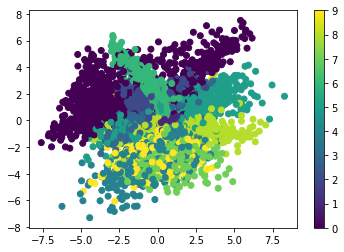

In [17]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
import matplotlib.pyplot as plt
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show() # display a 2D plot of the digit classes in the latent space
#encoder_log_var = Model(x,z_log_var)
#...#histogram

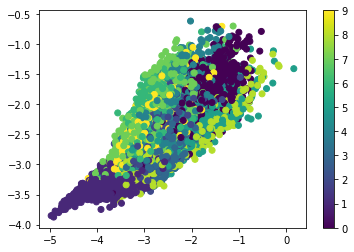

In [34]:
encoder_log_var = Model(x,z_log_var)
x_test_encoder_log_var = encoder_log_var.predict(x_test, batch_size=batch_size)
x_test_encoder_log_var


import matplotlib.pyplot as plt
plt.scatter(x_test_encoder_log_var[:, 0], x_test_encoder_log_var[:, 1], c=y_test)
plt.colorbar()
plt.show()

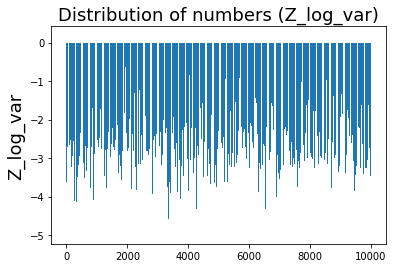

In [44]:


plt.bar(np.arange(len(x_test_encoder_log_var[:, 0])),x_test_encoder_log_var[:, 0])

plt.title('Distribution of numbers (Z_log_var)',fontsize=18)
plt.ylabel('Z_log_var',fontsize=18)

plt.show()

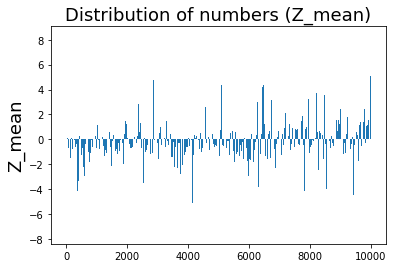

In [43]:
encoder_mean = Model(x,z_mean)
x_test_encoder_mean = encoder_mean.predict(x_test, batch_size=batch_size)
x_test_encoder_mean


plt.bar(np.arange(len(x_test_encoder_mean[:, 0])),x_test_encoder_mean[:, 0])

plt.title('Distribution of numbers (Z_mean)',fontsize=18)
plt.ylabel('Z_mean',fontsize=18)

plt.show()

> g) Genere nuevos datos artificialmente a través del espacio de las variables latentes. Para esto deberá generar puntos linealmente separados por debajo de la distribución Normal. Comente qué significada cada eje en la imagen ¿Qué sucede más allá en el espacio del 90% confianza de las variables latentes? ¿Qué objetos se generan?

Cada eje representa una de las dos variables latentes generadas por nuestro modelo.
Si tuvieramos que interpretar estas variables, diríamos que tienene que ver con la circularidad de la parte superior e inferior del número.

Más allá del intevalo de confianza se empiezan a generar combinaciones de números, que contienen mezclas de los valores de las variables latentes de distintos números.

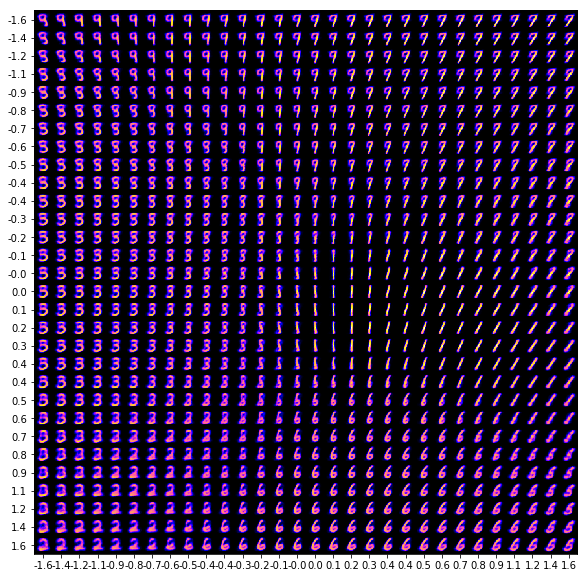

In [30]:
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_x_decoded_relu = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash) 
n = 30  # figure with 15x15 images 
image_size = img_cols
figure = np.zeros((image_size * n, image_size * n))
from scipy.stats import norm
grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) #metodo de la transformada inversa
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])            
        x_decoded = generator.predict(z_sample,batch_size=batch_size)
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = x_decoded[0][:,:,0]
plt.figure(figsize=(10, 10))
plt.imshow(figure,cmap='gnuplot2')
pos = np.arange(image_size/2,image_size*n,image_size)
plt.yticks(pos,np.round(grid_y,1))
plt.xticks(pos,np.round(grid_x,1))
plt.show()
grid = norm.ppf(np.linspace(0.000005, 0.999995, n)) #en los extremos del intervalo de confianza

> h) Experimente y comente si mejora o empeora el desempeño de clasificación de la representación encontrada al aumentar la dimensionalidad de las variables latentes $z$, contrarrestándolo con el AE tradicional ($d' = 2,8,16,32 $). Explique.